This notebook aims at introducing the framework considered for the Pytorch based optimisation.

Author: Francesco Capuano, S17 Summer 2022 Intern @ ELI beamlines, Prague.

# Motivation
Gradient-Free optimisation is a must-go in lots of areas in which it appears as the sole option, everyone seem to like it because of the very intuitive nature of some of the algorithms employed.

However, **it is generally sub-optimal**, both for what concerns convergence speed and quality of the found solutions. 

To sum up: black-box optimisation is really well performing when only access to $f$ is given, even if (when feasible) using $\nabla f$ (or, if possible $\nabla^2 f$) typically grants result of improved quality.

In this notebook, a python framework which supports great GPU-integration and **auto-differentiation** is used to demonstrate that, while certainly expensive in terms of knowledge and time, comprehension of the objective can be used to improve algorithms. The framework adopted is **Pytorch**. 

# Objective Function

In this notebook I will explore the optimisation of the $\mathbb R^2$-Ackley function, a particularly nasty non-linear non-convex function which is often used as a benchmark for optimisation algorithms. The function is then: 

$$
f(\boldsymbol{x}) = -a \cdot \exp \bigg( -b \cdot \sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2} \bigg) - exp \bigg( \frac 1d \sum_{i=1}^{d} \cos (cx_i) \bigg) + a + \exp(1)
$$

In this notebook the function's parameters are: 

1. $a = 20$

2. $b = 0.2$

3. $c = 2\pi$

4. $d = 2$

Which translates to the following `ackley` function (implemented using PyTorch API).

In [1]:
import torch

def ackley(x1:torch.tensor, x2:torch.tensor) -> torch.tensor: 
    r"""
    This function implements the 2D-Ackley function using pytorch tensors with a=20, b=0.2, c=2*\pi
    """
    a, b, c, d = 20, 0.2, 2 * torch.pi, 2
    
    first_part = -a * torch.exp(-b * torch.sqrt((1/d) * (x1**2 + x2**2)))
    second_part = -torch.exp((1/d) * (torch.cos(c * x1) + torch.cos(c * x2)))
    return first_part + second_part + a + torch.exp(torch.tensor(1))

/Users/francescocapuano/opt/anaconda3/envs/elienv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This function can be even be visualized with the following snippet

/Users/francescocapuano/opt/anaconda3/envs/elienv/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


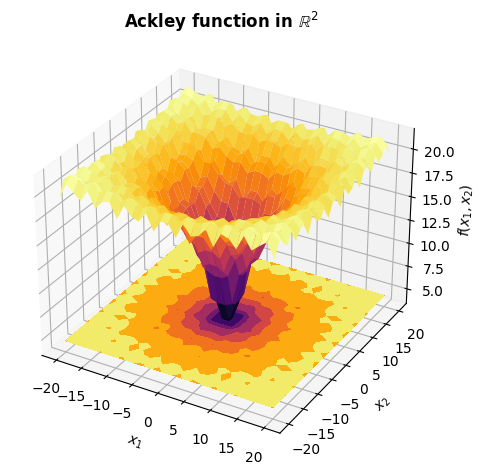

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x1, x2 = torch.linspace(-20, +20, steps = 30), torch.linspace(-20, +20, steps = 30)
X1, X2 = torch.meshgrid(x1, x2)
Z = ackley(X1, X2)

my_map = plt.cm.inferno

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$"); ax.set_zlabel(r"$f(x_1, x_2)$")

surf = ax.plot_surface(X1.numpy(), X2.numpy(), Z.numpy(), cmap = my_map)

cset = ax.contourf(X1.numpy(), X2.numpy(), Z.numpy(),
                   zdir ='z',
                   offset = np.min(Z.numpy()),
                   cmap = my_map)

ax.set_title(r"Ackley function in $\mathbb{R}^2$", fontweight = "bold")
fig.tight_layout()
plt.show()

Clearly enough not only this function is not convex, but it is not even an easy function to approximate when starting away from the global minimum, in $\mathbb R^2$ coincident with the space origin. 

The pytorch implementation grants the afore mentioned possibility of using differential information to carry out optimisation (in this case, mimimisation).
All it is necessary, is to carry out an evaluation of the objective function giving as input tensors which do store gradient information. Once again, in Pytorch this is a piece of cake.

In [3]:
x = (10 * torch.ones(2)).requires_grad_(True)
print(x.grad)

None


`x` now *can* store gradient information, but the gradient $\frac{\partial f}{\partial x}$ is not stored as long as a *backward* pass of $f$ is performed. This backward pass is what enables the unrolling of the computational graph and the **exact** computation of the gradient considered.

In [4]:
f_obj = ackley(*x)
f_obj.backward()
print(x.grad)

tensor([0.2707, 0.2707])


Now `x` stores gradient information. Great. To visualize this information it is possible to re-elaborate the afore presented plot. 

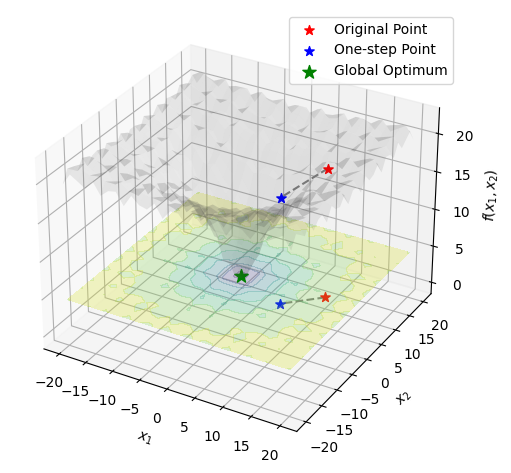

In [5]:
x1, x2, z = X1.numpy(), X2.numpy(), Z.numpy()

lr = 20

fig = plt.figure()
ax = plt.axes(projection='3d')

my_map = None

ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$"); ax.set_zlabel(r"$f(x_1, x_2)$")

surf = ax.plot_surface(x1, x2, z, cmap = my_map, alpha = .1, color = "grey")

cset = ax.contourf(x1, x2, z,
                   zdir ='z',
                   offset = np.min(z),
                   alpha = 0.25)

ax.scatter(*x.detach().numpy(),
           zs = ackley(*x).detach().numpy(),
           marker = "*",
           c = "red",
           s = 50,
           label = "Original Point")

ax.scatter(*(x.detach().numpy() - lr * x.grad.numpy()),
           zs = ackley(*(x - lr*x.grad)).detach().numpy(),
           marker = "*",
           c = "blue",
           s = 50,
           label = "One-step Point")

ax.plot(xs = [x[0].detach().numpy(), x[0].detach().numpy() - lr * x.grad[0].numpy()], 
        ys = [x[1].detach().numpy(), x[1].detach().numpy() - lr * x.grad[1].numpy()],
        zs = [ackley(*x).detach().numpy(), ackley(*(x - lr * x.grad)).detach().numpy()], 
        ls = "--",
        color = "grey")

ax.scatter(*x.detach().numpy(),
           marker = "*",
           c = "red",
           s = 50)

ax.plot(xs = [x[0].detach().numpy(), x[0].detach().numpy() - lr * x.grad[0].numpy()], 
        ys = [x[1].detach().numpy(), x[1].detach().numpy() - lr * x.grad[1].numpy()], 
        ls = "--",
        color = "grey")

ax.scatter(*(x.detach().numpy() - lr * x.grad.numpy()),
           marker = "*",
           c = "blue",
           s = 50)

ax.scatter(xs = 0,
           ys = 0,
           zs = np.min(z),
           marker = "*",
           c = "green",
           s = 100,
           label = "Global Optimum")

ax.legend()
fig.tight_layout()
plt.show()